**IMPORTANT** <br> <ul> <li> Do **NOT** replace or remove this notebook (ipynb file)! Each cell has unique nbgrader's metadata and ID which, if changed outside the nbgrader, cannot pass the tests. Do **NOT** change the name of the file!</li> <li> To receive any credit, don't forget to **SUBMIT** your notebook when you are done! You can have multiple submissions before the deadline; only the last one is saved, including its timestamp.</li> <li>Before submitting, **Validate** your notebook to check if your codes pass all visible tests. </li> <li>Make sure you fill in any cell with the comment `# your code here`. Remove or comment the command `fail()` (in R), or `raise NotImplementedError` (in Python) and place your code there </li> </ul>

In [2]:
NAME = "Daniel Kim"

In [3]:
import sys
print(sys.executable)

C:\Users\dmkim\anaconda3\python.exe


---

In [4]:
## if needed, install nose module first: pip install nose
# from nose.tools import assert_equal, assert_raises
import warnings
import numpy as np
from scipy import sparse
from scipy import ndimage
from sklearn.linear_model import Lasso, Ridge
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

## Compressive Sensing

Consider the reconstruction of an image of **computed tomography** (CT) from a set of parallel projections, acquired along different angles. 

Without any prior information on the sample, the number of projections required to reconstruct the image is of the order of the linear size ``l`` of the image (in pixels). For simplicity we consider here a sparse image, where only pixels on the boundary of objects have a non-zero value. Such data could correspond for example to a cellular material. Note however that most images are sparse in a different basis, such as the Haar wavelets. Only ``l/7`` projections are acquired, therefore it is necessary to use prior information available on the sample (its sparsity): this is an example of **compressive sensing**.

Now let's generate some synthetic image.

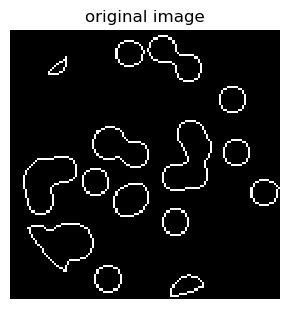

In [6]:
def generate_synthetic_data(rand_seed=0, l=128):
    """ Synthetic binary data """
    rs = np.random.RandomState(rand_seed)
    n_pts = 36
    x, y = np.ogrid[0:l, 0:l]
    mask_outer = (x - l / 2.) ** 2 + (y - l / 2.) ** 2 < (l / 2.) ** 2
    mask = np.zeros((l, l))
    points = l * rs.rand(2, n_pts)
    mask[(points[0]).astype(int), (points[1]).astype(int)] = 1
    mask = ndimage.gaussian_filter(mask, sigma=l / n_pts)
    res = np.logical_and(mask > mask.mean(), mask_outer)
    return np.logical_xor(res, ndimage.binary_erosion(res))

data = generate_synthetic_data()
plt.figure(figsize=(4, 3.5))
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('original image')
plt.show()

The tomography projection operation is a linear transformation. Reconstruction of the image based on the projection is a linear regression problem. We also penalize the norm of the image to account for its sparsity.

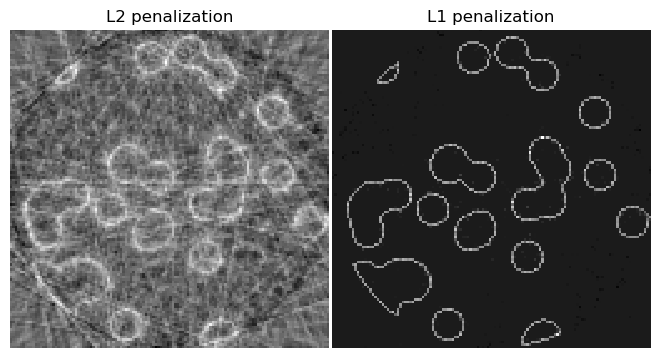

In [7]:
def _weights(x, dx=1, orig=0):
    x = np.ravel(x)
    floor_x = np.floor((x - orig) / dx).astype(np.int64)
    alpha = (x - orig - floor_x * dx) / dx
    return np.hstack((floor_x, floor_x + 1)), np.hstack((1 - alpha, alpha))

def _generate_center_coordinates(l_x):
    X, Y = np.mgrid[:l_x, :l_x].astype(np.float64)
    center = l_x / 2.
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y

def build_projection_operator(l_x, n_dir):
    """ Compute the tomography design matrix.

    Parameters
    ----------

    l_x : int
        linear size of image array

    n_dir : int
        number of angles at which projections are acquired.

    Returns
    -------
    p : sparse matrix of shape (n_dir l_x, l_x**2)
    """
    X, Y = _generate_center_coordinates(l_x)
    angles = np.linspace(0, np.pi, n_dir, endpoint=False)
    data_inds, weights, camera_inds = [], [], []
    data_unravel_indices = np.arange(l_x ** 2)
    data_unravel_indices = np.hstack((data_unravel_indices,
                                      data_unravel_indices))
    for i, angle in enumerate(angles):
        Xrot = np.cos(angle) * X - np.sin(angle) * Y
        inds, w = _weights(Xrot, dx=1, orig=X.min())
        mask = np.logical_and(inds >= 0, inds < l_x)
        weights += list(w[mask])
        camera_inds += list(inds[mask] + i * l_x)
        data_inds += list(data_unravel_indices[mask])
    proj_operator = sparse.coo_matrix((weights, (camera_inds, data_inds)))
    return proj_operator

# Generate projections
l = data.shape[0]
proj_operator = build_projection_operator(l, l // 7)
proj = proj_operator @ data.ravel()[:, np.newaxis]
proj += 0.15 * np.random.randn(*proj.shape) # add noise

# Reconstruction with L2 (Ridge) penalization
rgr_ridge = Ridge(alpha=0.2)
rgr_ridge.fit(proj_operator, proj.ravel())
rec_l2 = rgr_ridge.coef_.reshape(l, l)

# Reconstruction with L1 (Lasso) penalization
rgr_lasso = Lasso(alpha=0.001)
rgr_lasso.fit(proj_operator, proj.ravel())
rec_l1 = rgr_lasso.coef_.reshape(l, l)

# plot the reconstructions
plt.subplot(121)
plt.imshow(rec_l2, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L2 penalization')
plt.axis('off')
plt.subplot(122)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L1 penalization')
plt.axis('off')
plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
plt.show()

Now generate a new synthetic image using `rand_seed=2023` and the projections as well.

In [15]:
rand_seed=2023
np.random.seed(rand_seed)

data = generate_synthetic_data(rand_seed=rand_seed,l=64)
l = data.shape[0]
proj_operator = build_projection_operator(l, l // 7)
proj = proj_operator @ data.ravel()[:, np.newaxis]
proj += 0.05 * np.random.randn(*proj.shape) # add noise

### Questions

1. Reconstruct the image from projections using Lasso, with regularization parameter $\alpha$ obtained by 5-fold cross validation. Store your fitting result in **rgr_lasso**.

In [22]:
from sklearn.linear_model import LassoCV

rgr_lasso = LassoCV(cv=5).fit(proj_operator, proj.ravel())

Compare the actual image (saved as `data`) with $\ell_1$ reconstruction (saved as `rec_l1`) in the following plot.

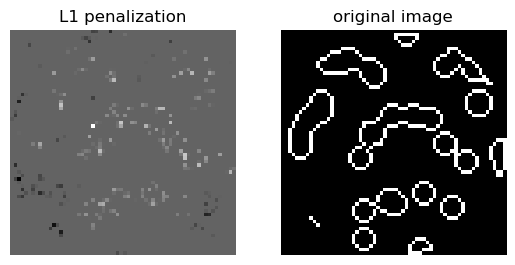

<Figure size 640x480 with 0 Axes>

In [23]:
rec_l1 = rgr_lasso.coef_.reshape(l, l)

plt.subplot(121)
plt.imshow(rec_l1, cmap=plt.cm.gray, interpolation='nearest')
plt.title('L1 penalization')
plt.axis('off')

plt.subplot(122)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('original image')
plt.show()

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
plt.show()


2. Reconstruct the image from projections using Elastic-Net, with regularization parameter $\alpha$ and $l1\_ratio$ obtained by 5-fold cross validation. Store your fitting result in **rgr_enet**.

You might need to set higher max iteration for cross validation in this case.

In [25]:
from sklearn.linear_model import ElasticNetCV

l1_list = [.8, .85, .9, .95]
rgr_enet = ElasticNetCV(cv=5, l1_ratio= l1_list, max_iter=3000).fit(proj_operator, proj.ravel())

Compare the actual image (saved as `data`) with Elastic-Net reconstruction (saved as `rec_enet`) in the following plot.

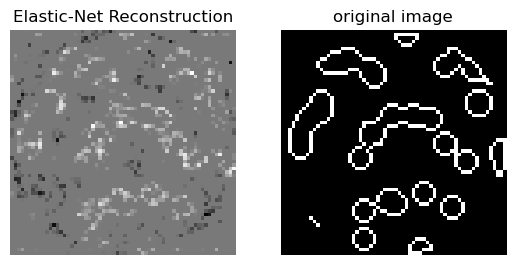

<Figure size 640x480 with 0 Axes>

In [26]:
rec_enet = rgr_enet.coef_.reshape(l, l)

plt.subplot(121)
plt.imshow(rec_enet, cmap=plt.cm.gray, interpolation='nearest')
plt.title('Elastic-Net Reconstruction')
plt.axis('off')

plt.subplot(122)
plt.imshow(data, cmap=plt.cm.gray, interpolation='nearest')
plt.axis('off')
plt.title('original image')
plt.show()

plt.subplots_adjust(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
plt.show()